# **Check GPU**

In [1]:
# Check the GPU model:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-981912e7-585f-49c2-1ad9-600372b88670)


In [2]:
## Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
#!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.14.0-dev20230620
Notebook last run (end-to-end): 2023-06-21 10:34:45.761752


# **Helper Functions**

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# **Download Data**

In [5]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-06-21 10:34:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4005:803::2010, 2607:f8b0:4005:801::2010, 2607:f8b0:4005:812::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4005:803::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: '101_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0% 1.76M 14m43s
    50K .......... .......... .......... .......... ..........  0% 4.53M 10m12s
   100K .......... .......... .......... .......... ..........  0% 6.71M 8m5s
   150K .......... .......... .......... .......... ..........  0% 7.17M 6m58s
   200K .......... .......... .......... .......... ..........  0% 7.00M 6m19s
   250K .......... .......... .......... .......... ..........  0% 6.61M 5m55s
   300K .......... ......

In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

# ------------------

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for predic

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
## Take one sample off the training data
train_one_sample = train_data_all_10_percent.take(1) # samples are in format (image_tensor, label)

In [9]:
## What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  """)


  Image shape: (32, 224, 224, 3)
  Image dtype: <dtype: 'float32'>
  


In [11]:
# What does an image tensor look like?
image

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[208.65306   , 250.72449   , 254.41327   ],
         [208.59694   , 250.66837   , 252.93367   ],
         [209.66327   , 251.7347    , 253.22449   ],
         ...,
         [213.07143   , 245.57654   , 224.57654   ],
         [210.14288   , 245.28067   , 225.23474   ],
         [210.4438    , 248.4438    , 227.4438    ]],

        [[125.24488   , 158.60204   , 173.17346   ],
         [164.68367   , 199.0357    , 210.68877   ],
         [194.46428   , 229.41837   , 240.07652   ],
         ...,
         [206.71432   , 241.57147   , 221.6429    ],
         [210.14798   , 248.01534   , 227.08167   ],
         [210.49992   , 250.449     , 229.11734   ]],

        [[112.36224   , 132.86224   , 157.93367   ],
         [111.515305  , 132.41325   , 157.2857    ],
         [112.79591   , 136.4898    , 160.62755   ],
         ...,
         [207.        , 245.57147   , 225.21426   ],
         [207.98465   , 249.98465   , 227.44382

In [12]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=255.0>)

In [13]:
#print("This is the shape of the Sample image:",image.shape, "\n")
#resize_image = tf.image.resize(image, [244, 244])
#print("This is the shape of resized image",resize_image.shape)

In [14]:
# Plot an image tensor
# import matplotlib.pyplot as plt
# import torchvision as torchvision
# plt.imshow(torchvision.utils.make_grid(image, nrow=5).permute(1, 2, 0))
# plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
# plt.axis(False);

In [15]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights o

# **Setup mixed precision training**

In [16]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [17]:
## Turn on mixed precision training
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

In [18]:
# mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

In [19]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
# x = layers.Dense(len(train_data_all_10_percent.class_names))(x) # same number of outputs as classes
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
## Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

In [20]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [21]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=3, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/3
237/237 [==============================] - 222s 909ms/step - loss: 3.3782 - accuracy: 0.2727 - val_loss: 2.4755 - val_accuracy: 0.4597
Epoch 2/3
237/237 [==============================] - 220s 928ms/step - loss: 2.2010 - accuracy: 0.5007 - val_loss: 2.0325 - val_accuracy: 0.5228
Epoch 3/3
237/237 [==============================] - 216s 914ms/step - loss: 1.8238 - accuracy: 0.5667 - val_loss: 1.8868 - val_accuracy: 0.5312


In [22]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 469s 594ms/step - loss: 1.7034 - accuracy: 0.5669


[1.7033993005752563, 0.5669307112693787]

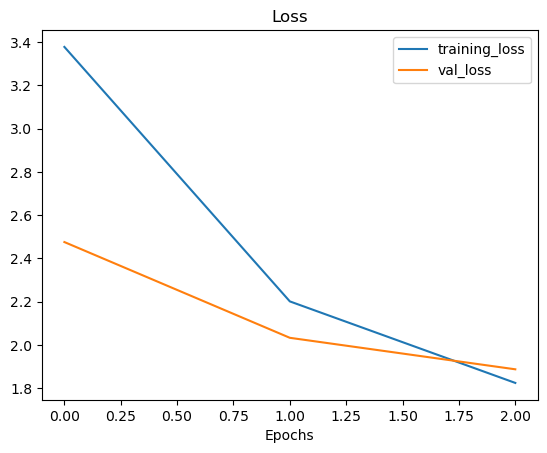

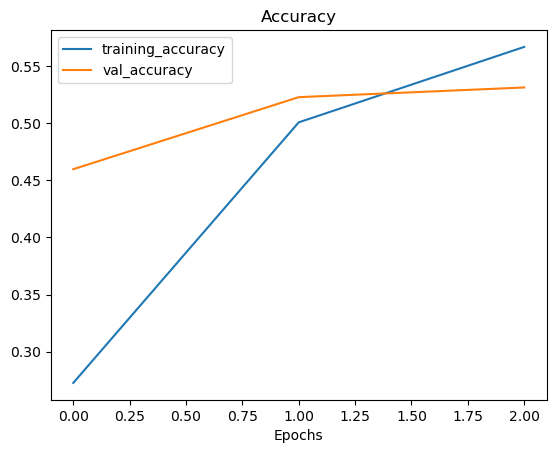

In [23]:
plot_loss_curves(history_all_classes_10_percent)

# **Fine-tuning**

In [24]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [25]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [26]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [27]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [28]:
# Fine-tune for 3 more epochs
fine_tune_epochs = 6 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 3/6
237/237 [==============================] - 229s 938ms/step - loss: 1.4616 - accuracy: 0.6207 - val_loss: 1.7887 - val_accuracy: 0.5297
Epoch 4/6
237/237 [==============================] - 219s 924ms/step - loss: 1.3079 - accuracy: 0.6610 - val_loss: 1.7410 - val_accuracy: 0.5440
Epoch 5/6
237/237 [==============================] - 219s 927ms/step - loss: 1.2120 - accuracy: 0.6797 - val_loss: 1.7634 - val_accuracy: 0.5405
Epoch 6/6
237/237 [==============================] - 216s 910ms/step - loss: 1.1350 - accuracy: 0.6941 - val_loss: 1.7357 - val_accuracy: 0.5466


In [29]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 434s 549ms/step - loss: 1.4991 - accuracy: 0.5969


[1.4991027116775513, 0.5968713164329529]

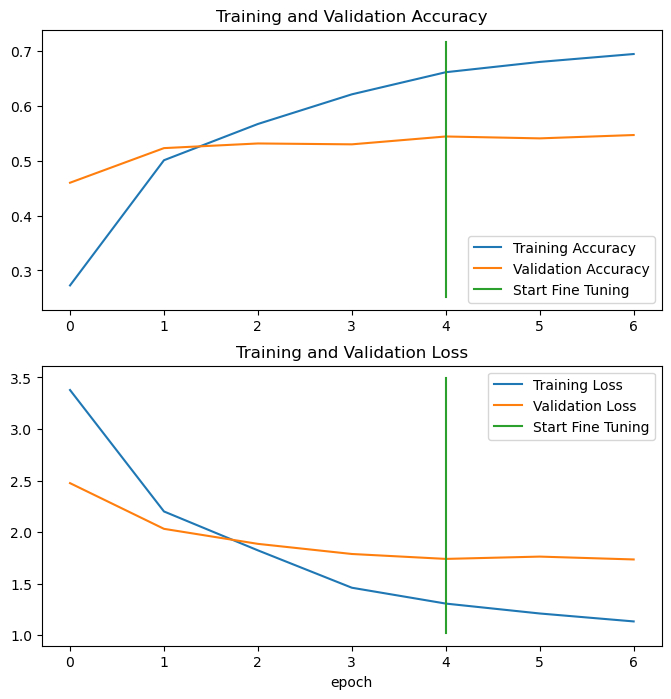

In [30]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# **Saving our trained model**

In [31]:
# # Save model to drive so it can be used later 
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

# **Making predictions with our trained model**

In [32]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 432s 545ms/step


In [33]:
# How many predictions are there?
len(pred_probs)

25250

In [34]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [35]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [36]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.34400317e-01 3.05524271e-04 8.90663788e-02 1.95814118e-06
 3.63364597e-05 9.73031456e-06 4.07644548e-04 2.06213044e-05
 2.71955281e-02 1.61635585e-03 5.78251365e-06 1.05332865e-05
 1.53316325e-03 1.88099375e-06 1.24268206e-02 3.74265341e-03
 1.90068153e-04 7.07937288e-04 9.17445682e-03 3.11647200e-05
 4.52063861e-04 4.46360391e-05 3.53387673e-04 1.69746389e-04
 2.64957751e-04 2.19326024e-03 1.40363956e-03 1.52048568e-04
 1.59665838e-01 1.05857430e-03 1.49284460e-05 2.15865974e-03
 4.14075039e-04 1.97601889e-06 1.23282969e-02 6.08053051e-05
 6.03166118e-04 3.36120813e-03 5.32493331e-02 1.43942147e-04
 6.58838253e-04 1.72236352e-03 4.59631032e-04 1.23574473e-05
 2.71421130e-04 1.68280185e-05 5.35267405e-03 8.71179363e-05
 3.61774551e-06 1.10008515e-01 4.71391861e-04 3.30950716e-05
 6.84292391e-02 3.57193910e-02 1.26100840e-05 7.28631066e-03
 4.85786004e-03 2.11142539e-03 4.78093140e-

In [37]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 72,  9,  0], dtype=int64)

In [38]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [39]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

# **Evaluating models predictions**

In [40]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5968712871287128

In [41]:
## Does the evaluate method compare to the Scikit-Learn measured accuracy?
# import numpy as np
# print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

In [42]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [43]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [44]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [45]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.16      0.22       250
           1       0.41      0.78      0.54       250
           2       0.72      0.54      0.61       250
           3       0.79      0.54      0.64       250
           4       0.53      0.41      0.46       250
           5       0.50      0.35      0.41       250
           6       0.76      0.77      0.76       250
           7       0.83      0.77      0.80       250
           8       0.28      0.52      0.37       250
           9       0.43      0.64      0.51       250
          10       0.62      0.36      0.45       250
          11       0.76      0.63      0.69       250
          12       0.68      0.64      0.66       250
          13       0.50      0.58      0.54       250
          14       0.50      0.53      0.52       250
          15       0.42      0.35      0.38       250
          16       0.62      0.64      0.63       250
          17       0.40    

In [47]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3178294573643411,
  'recall': 0.164,
  'f1-score': 0.21635883905013192,
  'support': 250},
 '1': {'precision': 0.40842105263157896,
  'recall': 0.776,
  'f1-score': 0.5351724137931034,
  'support': 250},
 '2': {'precision': 0.7204301075268817,
  'recall': 0.536,
  'f1-score': 0.6146788990825689,
  'support': 250},
 '3': {'precision': 0.7906976744186046,
  'recall': 0.544,
  'f1-score': 0.6445497630331752,
  'support': 250},
 '4': {'precision': 0.5309278350515464,
  'recall': 0.412,
  'f1-score': 0.46396396396396394,
  'support': 250},
 '5': {'precision': 0.49714285714285716,
  'recall': 0.348,
  'f1-score': 0.40941176470588236,
  'support': 250},
 '6': {'precision': 0.758893280632411,
  'recall': 0.768,
  'f1-score': 0.7634194831013917,
  'support': 250},
 '7': {'precision': 0.8275862068965517,
  'recall': 0.768,
  'f1-score': 0.7966804979253111,
  'support': 250},
 '8': {'precision': 0.2841648590021692,
  'recall': 0.524,
  'f1-score': 0.3684950773558368,
  'supp

In [48]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.21635883905013192,
 'baby_back_ribs': 0.5351724137931034,
 'baklava': 0.6146788990825689,
 'beef_carpaccio': 0.6445497630331752,
 'beef_tartare': 0.46396396396396394,
 'beet_salad': 0.40941176470588236,
 'beignets': 0.7634194831013917,
 'bibimbap': 0.7966804979253111,
 'bread_pudding': 0.3684950773558368,
 'breakfast_burrito': 0.512,
 'bruschetta': 0.45177664974619286,
 'caesar_salad': 0.6884531590413944,
 'cannoli': 0.6611909650924025,
 'caprese_salad': 0.5363128491620112,
 'carrot_cake': 0.5175097276264591,
 'ceviche': 0.3815789473684211,
 'cheese_plate': 0.6274509803921569,
 'cheesecake': 0.3584070796460177,
 'chicken_curry': 0.5056433408577878,
 'chicken_quesadilla': 0.6640776699029126,
 'chicken_wings': 0.7265625,
 'chocolate_cake': 0.5557586837294333,
 'chocolate_mousse': 0.37541528239202665,
 'churros': 0.7331975560081466,
 'clam_chowder': 0.7142857142857142,
 'club_sandwich': 0.6330935251798561,
 'crab_cakes': 0.37067209775967414,
 'creme_brulee': 0.772925764192

In [49]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33    edamame  0.976190
69    oysters  0.869023
32  dumplings  0.855397
63   macarons  0.848214
86    sashimi  0.846626

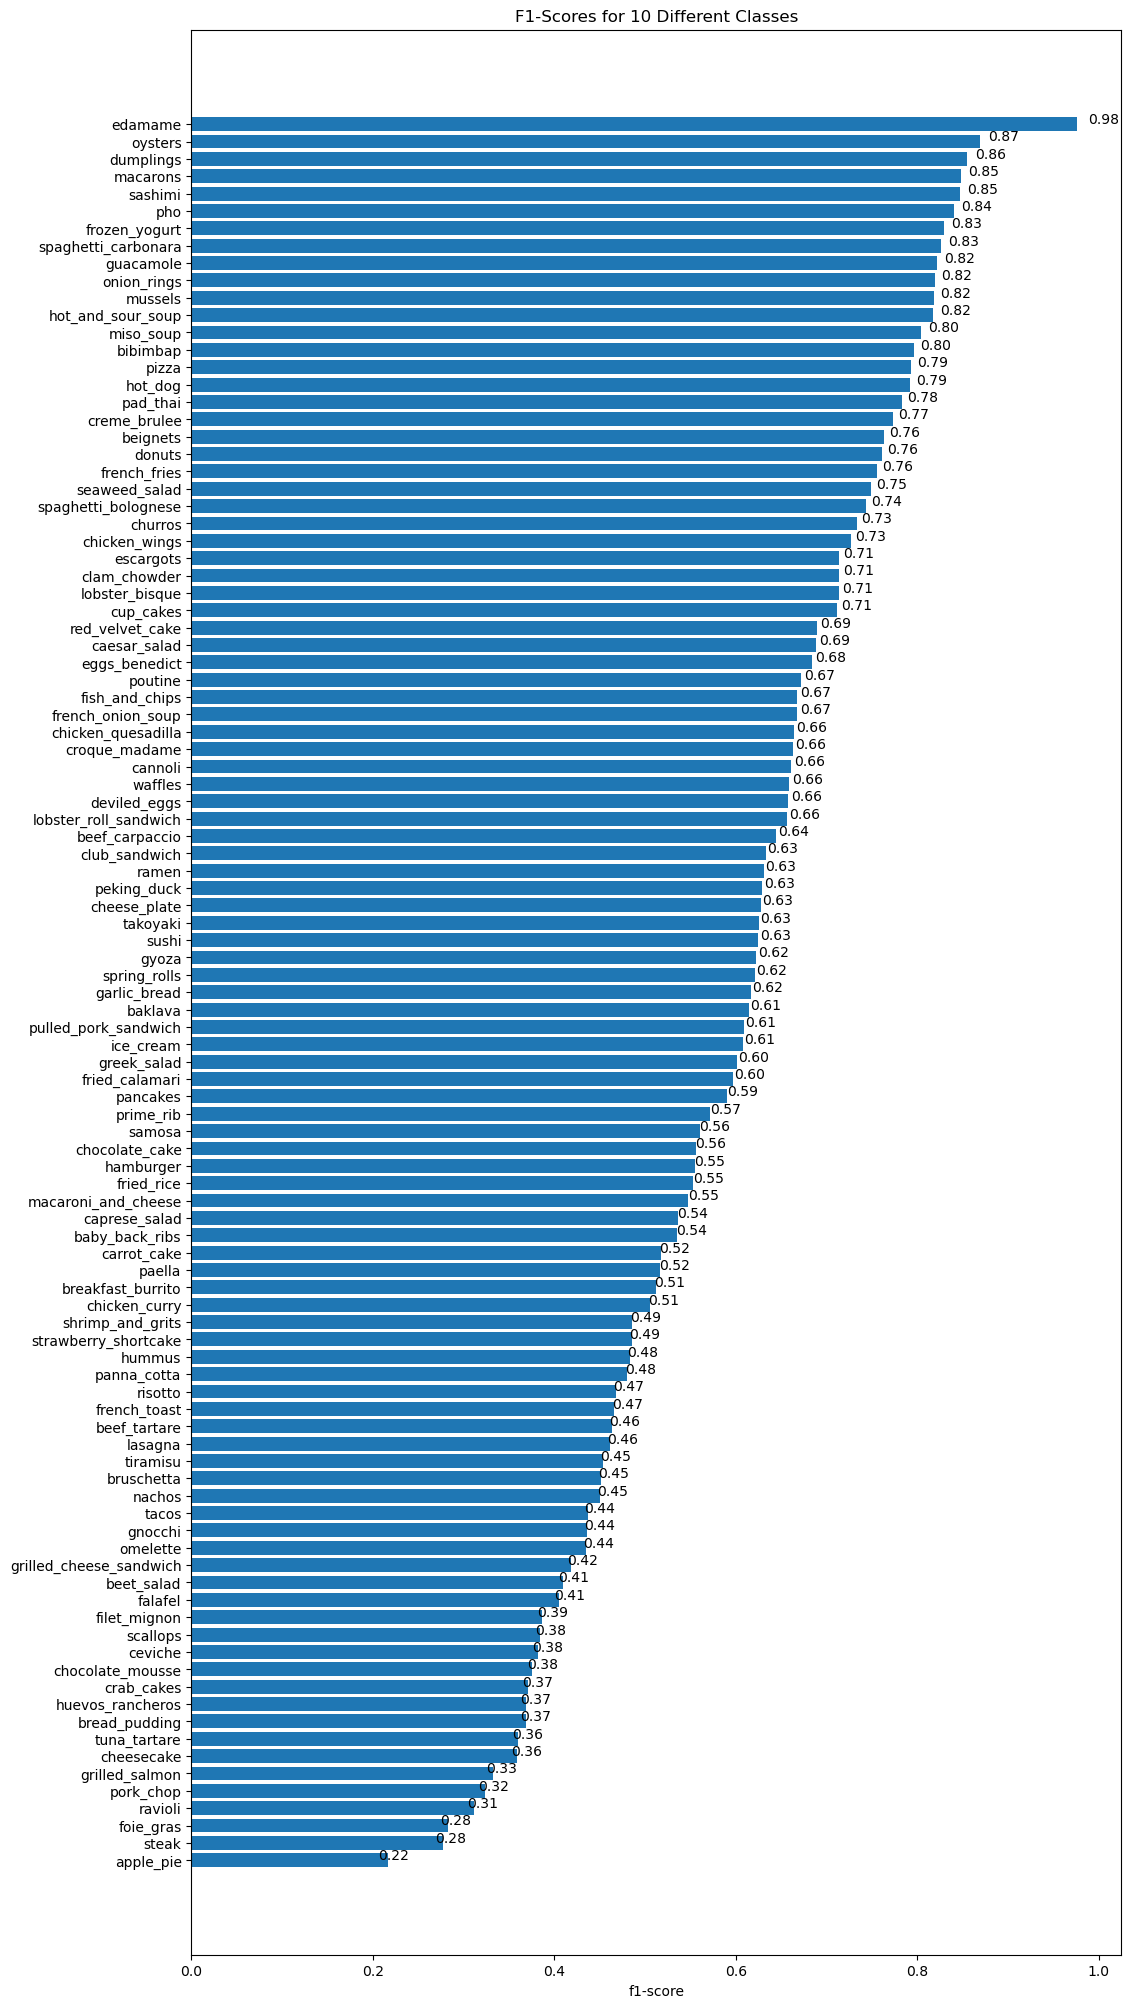

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Let's load a few random images from the test dataset, make predictions on them, and plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.


In [51]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 35ms/step


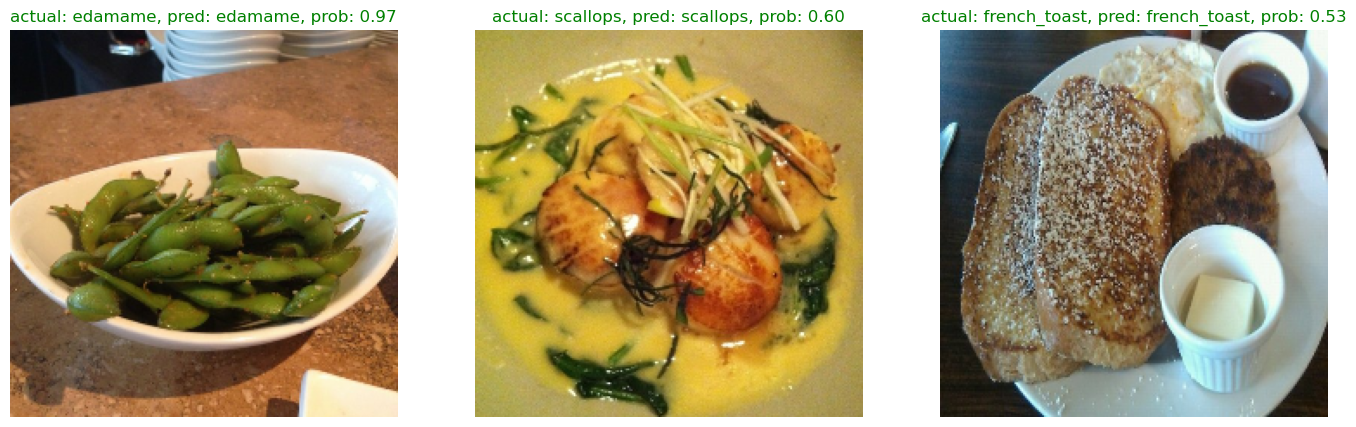

In [52]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# **Finding the most wrong predictions**

In [53]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [54]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0      38   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.234400        apple_pie        apple_pie  
1   0.911406        apple_pie        apple_pie  
2   0.506916        apple_pie        apple_pie  
3   0.189815        apple_pie   fish_and_chips  
4   0.643905        apple_pie    bread_pudding

In [55]:
# 3. Are predictions correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0      38   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.234400        apple_pie        apple_pie          True  
1   0.911406        apple_pie        apple_pie          True  
2   0.506916        apple_pie        apple_pie          True  
3   0.189815        apple_pie   fish_and_chips         False  
4   0.643905        apple_pie    bread_pudding         False

In [56]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent\\test\\sushi\\16...      95      86   
191    b'101_food_classes_10_percent\\test\\apple_pie...       0      31   
15359  b'101_food_classes_10_percent\\test\\lobster_r...      61      53   
23300  b'101_food_classes_10_percent\\test\\steak\\17...      93       1   
3031   b'101_food_classes_10_percent\\test\\cannoli\\...      12      98   
23631  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
10741  b'101_food_classes_10_percent\\test\\french_to...      42       1   
22606  b'101_food_classes_10_percent\\test\\spaghetti...      90       1   
18001  b'101_food_classes_10_percent\\test\\pancakes\...      72      67   
10346  b'101_food_classes_10_percent\\test\\french_on...      41      54   
17855  b'101_food_classes_10_percent\\test\\paella\\2...      71      65   
14630  b'101_food_classes_10_percent\\test\\ice_cream...      58      78   
4583   b'101_food_classes_10_percent\\test\\chicken_c...      18      60   
11642  b'101_food_classes_10_percent\\test\\garlic_br...      46      10   
7295   b'101_food_classes_10_percent\\test\\cup_cakes...      29      31   
10277  b'101_food_classes_10_percent\\test\\french_on...      41      54   
20214  b'101_food_classes_10_percent\\test\\pulled_po...      80      53   
733    b'101_food_classes_10_percent\\test\\baklava\\...       2      12   
14691  b'101_food_classes_10_percent\\test\\ice_cream...      58      79   
8794   b'101_food_classes_10_percent\\test\\escargots...      35      41   

       pred_conf       y_true_classname   y_pred_classname  pred_correct  
23797   0.998372                  sushi            sashimi         False  
191     0.996681              apple_pie             donuts         False  
15359   0.994064  lobster_roll_sandwich          hamburger         False  
23300   0.991939                  steak     baby_back_ribs         False  
3031    0.990514                cannoli           tiramisu         False  
23631   0.990330   strawberry_shortcake    red_velvet_cake         False  
10741   0.990219           french_toast     baby_back_ribs         False  
22606   0.989988    spaghetti_bolognese     baby_back_ribs         False  
18001   0.988566               pancakes           omelette         False  
10346   0.988278      french_onion_soup  hot_and_sour_soup         False  
17855   0.985891                 paella            mussels         False  
14630   0.985767              ice_cream            poutine         False  
4583    0.985714          chicken_curry     lobster_bisque         False  
11642   0.984675           garlic_bread         bruschetta         False  
7295    0.984434              cup_cakes             donuts         False  
10277   0.984350      french_onion_soup  hot_and_sour_soup         False  
20214   0.984335   pulled_pork_sandwich          hamburger         False  
733     0.983956                baklava            cannoli         False  
14691   0.983769              ice_cream          prime_rib         False  
8794    0.983195              escargots  french_onion_soup         False

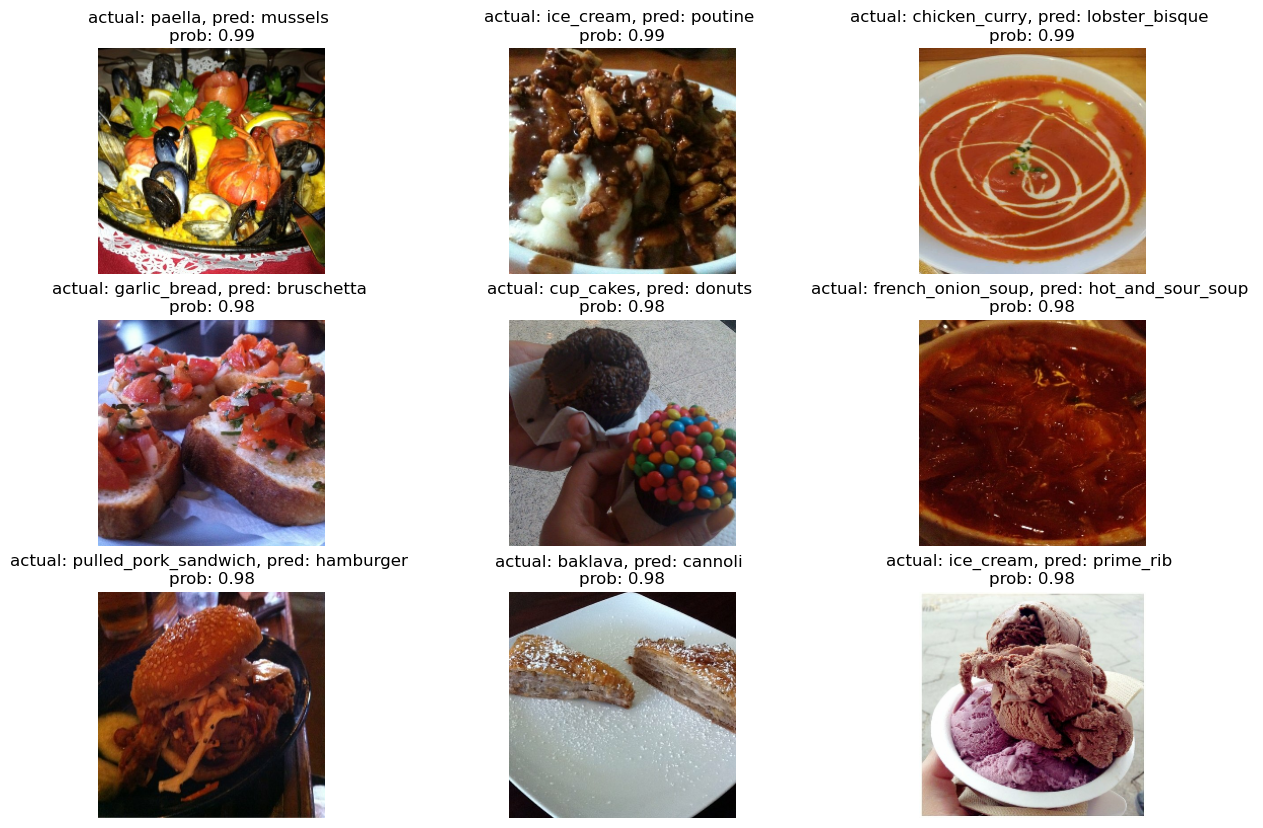

In [57]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

TODOs:
1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:

+ A confusion matrix between all of the model's predictions and true labels.

+ A graph showing the f1-scores of each class.

+ A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?